## Lab- Linear Regression with L2 Regularization - Bias-Variance tradeoff

**Objectives**: Implement Regularized Linear Regression algorithm and use it to study the bias-variance tradeoff.

In [4]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

### Loading the data

The task is to implement regularized linear regression to predict the amount of water owing out of a dam using the change of water level in a reservoir. 

You will examine the effects of bias versus variance.

File *ex5data1.mat* contains historical records on the change in the water level, x, and the amount of water owing out of the dam, y. The dataset is divided into the following parts:

• Training set ( X, y) used to fit the model.

• Cross Validation (CV) / dev set (Xval, yval) for determining the regularization parameter.

• Test set (Xtest, ytest) for evaluating performance. These are examples which the model did not see during training. 


In [5]:
# Use loadmat to load the matlab file ex5data1.mat and extract train, val and test subsets. 
data = loadmat("ex5data1.mat")

X = data['X']
y = data['y']

Xval = data['Xval']
yval = data['yval']

Xtest = data['Xtest']
ytest = data['ytest']

m = len(y)  # Number of training examples 
mval = len(yval) # Number of CV/dev examples 
mtest = len(ytest)  # Number of testing examples

### Plot the training data

<img src="images/f1.png" style="width:350px;height:250px;">
<caption><center> Fig. 1 : Training data </center></caption>

Text(0, 0.5, 'Water flowing out of the dam')

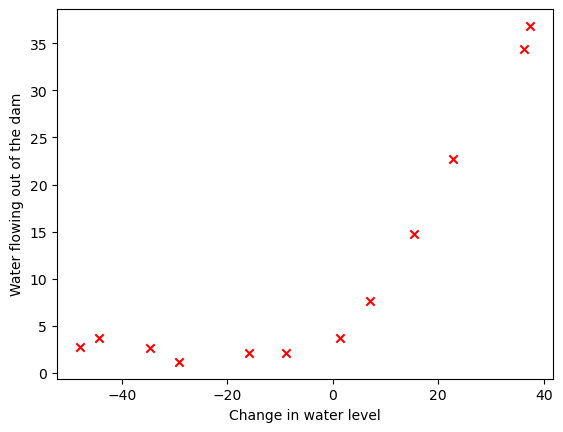

In [6]:
# Plot the training data and get a figure similar to Fig.1. (use for example plt.scatter)
plt.scatter(X, y, marker="x", color="r")
plt.xlabel("Change in water level")
plt.ylabel("Water flowing out of the dam")

### Regularized Linear Regression Cost (Loss) Function

You will implement Linear Regression to fit a straight line to the data and plot the learning curves. 

The regularized Linear Regression Cost (Loss) Function is:

$J(\theta) = \frac{1}{2m} (\sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})^2) + \frac{\lambda}{2m}(\sum_{j=1}^n \theta_j^2)$

$\lambda$ is the regularization parameter which helps preventing overfitting. The regularization term puts a penalty on the overall cost $J(\theta)$. By default $\theta_0$ parameter is not regularized.

Complete the code in function *linearRegCostFunction* to calculate the Regularized Linear Regression Cost function and its gradients with respect to vector of trainable parameters  $\theta$. 

In [7]:
def linearRegCostFunction(X, y, theta, Lambda):
    
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the linear regression model.
    
    """
    
    # number of training examples 
    m = len(y)
    
    # linear regression model
    h = np.dot(X, theta)
    
    cost = 1/(2*m) * np.sum((h - y)**2)
    reg_cost = cost + Lambda/(2*m) * (np.sum(theta[1:]**2))
    
    # compute the gradients
    grad_0= (1/m) * np.dot(X.transpose(),(h - y))[0]
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    #  all gradients as a column vector
    grad_all=np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return reg_cost, grad_all
    

### PART 1: Fitting Linear Regression

Here, we set the regularization parameter $\lambda$ = 0. For this exercise, Linear regression fits vector $\theta$ with only 2 elements (theta0, theta_1), because we have only one feature, regularization will not be much helpful. 

In [8]:
def gradientDescent(X,y,theta,learn_rate,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history =[]
    
    for i in range(num_iters):
        cost, grad = linearRegCostFunction(X,y,theta,Lambda)
        
        # update theta
        theta = theta - (learn_rate * grad)
        J_history.append(cost)
    
    return theta, J_history

In [9]:
# add an extra columns of 1 to X (consult previous labs) 
X_1 = np.append(np.ones((m, 1)), X, axis=1)

Lambda = 0
learn_rate = 0.001

# choose an adequate number of iterations such that the cost function converged 
num_iter = 3000 # or 2600

# inicialize all trainable parameters to be zeros.
n = X_1.shape[1]
initial_theta = np.zeros((n, 1))

# Run gradientDescent to compute the optimal values of theta : 
# EXPECTED RESULT: theta= [~12; ~0.36]
theta, J_history = gradientDescent(X_1, y, initial_theta, learn_rate, num_iter, Lambda)

print("theta = ", theta)

theta =  [[12.37477348]
 [ 0.36350229]]


### Plot the Cost Function history

Text(0, 0.5, 'J(Θ)')

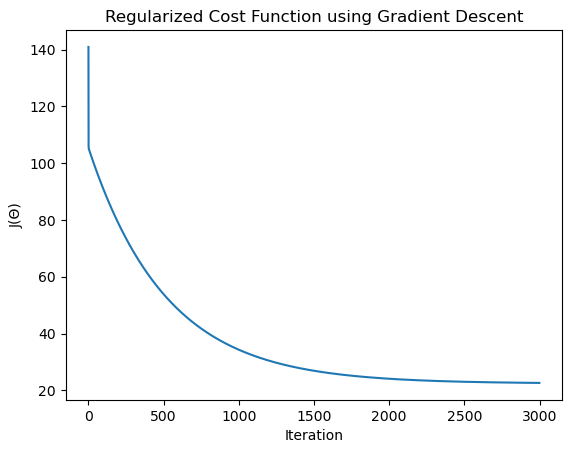

In [10]:
plt.plot(J_history)
#add labels
plt.title("Regularized Cost Function using Gradient Descent")
plt.xlabel("Iteration")
plt.ylabel("J(Θ)")

### Plot the data and its linear model
You should get a figure similar to Fig.2. This best fit line tells that the linear model is not a good fit to this data. 

<img src="images/f2.png" style="width:350px;height:250px;">
<caption><center> **Fig.2** : **Linear fit** </center></caption>

(-50.0, 40.0)

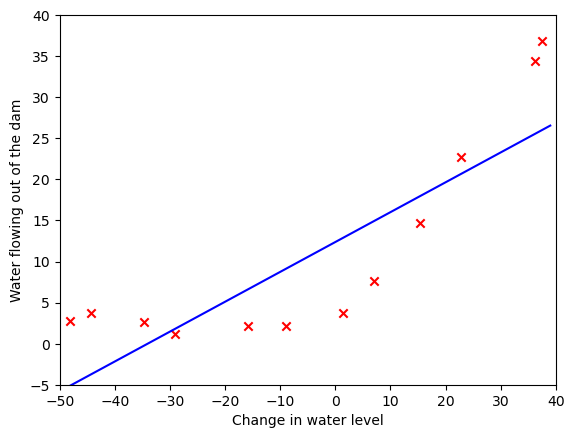

In [11]:
#add the scatter plot of data (as above) 
plt.scatter(X, y, marker="x", color="r")
plt.xlabel("Change in water level")
plt.ylabel("Water flowing out of the dam")

#Plot the best linear model
x_fit=range(-50,40)
y_fit=theta[0]+theta[1]*x_fit
plt.plot(x_fit,y_fit,color="b")

plt.ylim(-5,40)
plt.xlim(-50,40)

### Bias-variance and learning curves 

An important concept in ML is the **bias-variance** tradeoff. 

Models with high bias are not complex enough for the data and tend to underfit. 

Models with high variance overfit to the training data. 

Now, you will plot training and CV learning curves to diagnose bias-variance problems. 

To plot the learning curve, we need training and CV errors for different training set sizes. To obtain different training set sizes, *learningCurve* use different subsets of the original training set X. Specifically, for a training set size of i, the first i examples (i.e., X(0:i,:) and y(0:i)) are used.


In [12]:
def learningCurve(X, y, Xval, yval, learn_rate, num_iter, Lambda):
    
    """
    Returns the train and cross validation set errors for a learning curve
    """
   
    m = len(y)  # Number of training examples 
    n = X.shape[1]  # number of features 
    mval = len(yval)  # Number of validation examples 

    error_train, error_val = [],[]
    
    for i in range(1,m+1):
        
        # inicialize theta vector with zeros
        initial_theta = np.zeros((n, 1))
        Xtrain=X[0:i,:]
        ytrain=y[0:i,:]
        
        #compute the optimal theta
        theta = gradientDescent( Xtrain, ytrain,initial_theta,learn_rate,num_iter,Lambda)[0]
        
        h_train = np.dot(Xtrain, theta)
        h_val = np.dot(Xval, theta)
        
        error_train_i = 1/(2*m) * np.sum((h_train - ytrain)**2)
        error_val_i = 1/(2*mval) * np.sum((h_val - yval)**2)
        
        error_train.append(error_train_i)
        error_val.append(error_val_i)

    return error_train, error_val

In [13]:
# add an extra columns of 1 to Xval
mval = Xval.shape[0]
Xval_1 = np.append(np.ones((mval, 1)), Xval, axis=1)

#Call learningCurve to compute error_train and error_validation
error_train, error_val = learningCurve(X_1, y, Xval_1, yval, learn_rate, num_iter, Lambda)

# print("Training error: ", error_train)
# print("Validation error: ", error_val)

### Plot the learning curves

Plot the learning curves as shown in Fig. 3. You can observe that both the training and the cross validation errors are high even when the number of training examples increases. This reflects a high bias problem of the model. 

<img src="images/f3.png" style="width:350px;height:250px;">
<caption><center> **Fig.3** : **Linear Regression learning curves** </center></caption>

(-10.0, 210.0)

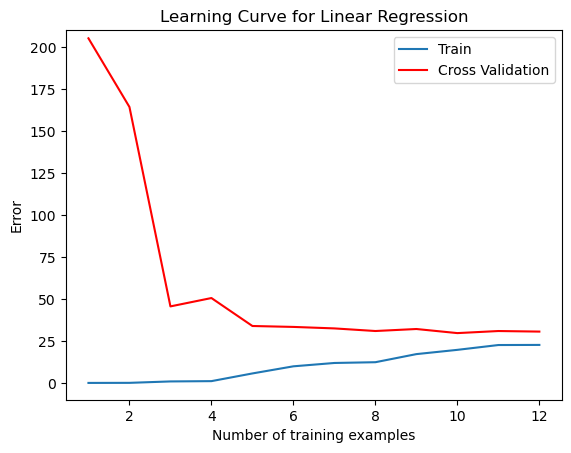

In [14]:
plt.plot(range(1,m+1),error_train)
plt.plot(range(1,m+1), error_val,color="r")
plt.title("Learning Curve for Linear Regression")
plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.legend(["Train", "Cross Validation"])
plt.ylim(-10,210)

### Polynomial Regression

The linear model is too simple for this data and resulted in underfitting (high bias). Now, you will address this problem by adding more features using higher powers of the original feature (waterLevel), such as:

<img src="images/f4.png" style="width:450px;height:50px;">
<caption><center> Fig.4: Polynomial Regression model </center></caption>

Even though we have polynomial terms in the model above, we are still solving a linear regression optimization problem. The polynomial terms are simply new features that we can use for linear regression.

Your task is to complete the function *polyFeatures* so that it maps the original training set X of size mx1 into its higher powers.

$X_{poly}=[X^1, X^2,....X^n]$ 

Function *polyFeatures* has to be applied to the training, cross validation and test sets. 
  

In [15]:
def polyFeatures(X, degree):
    """
    Takes a data matrix X (size m x 1) and maps each example into its polynomial features where 
    X_poly(i, :) = [X(i) X(i).^2 X(i).^3 ...  X(i).^degree];
    """
    m = X.shape[0]  # Number of training examples 
    
    for i in range(2,degree+1):
        var=X[:,0]**i
        X = np.append(X, var.reshape(m,1), axis=1)
        
    return X

### Feature Normalization

After adding polynomial terms, the new features are badly scaled. Let assume a polynomial of degree 8, an example with x = 40 will now have a feature x8 = 40^8 = 6.5x10^12. Therefore, before training the model, the features of the training set are first normalized. Here *StandardScaler()* function is used, that standardize the features by removing the mean and scaling to unit variance. Check *StandardScaler?* for more details. 

In [16]:
from sklearn.preprocessing import StandardScaler

# Map X onto Polynomial features (call polyFeatures)
degree = 8
X_poly = polyFeatures(X, degree)

# Check the range of values for the polynomial features,use for example np.max(), np.min()
print("Max polynomial features: ", np.max(X_poly))
print("Min polynomial features: ", np.min(X_poly))

# Standardize the features by removing the mean and scaling to unit variance. 
sc_X=StandardScaler()
sc_X.fit(X_poly)  #Fit the scaller ONLY to the TRAINING DATA
X_poly_normalized=sc_X.transform(X_poly) #Transform the training data 

# Check the range of values for the standardized features 
print("Max polynomial features normalized: ", np.max(X_poly_normalized))
print("Min polynomial features normalized: ", np.min(X_poly_normalized))

# Add an extra column of 1' to X_poly
pn = X_poly_normalized.shape[0]
X_poly_normalized = np.append(np.ones((pn, 1)), X_poly_normalized, axis=1)

Max polynomial features:  28456763821657.78
Min polynomial features:  -592123531634.1227
Max polynomial features normalized:  2.8890818199263832
Min polynomial features normalized:  -2.76331690131688


Map CV and test sets to polynomial features. 
Apply the fitted (with the training data) scaler to them. 

DO NOT FIT AGAIN THE SCALER !!!

In [17]:
# Map Xval and Xtest onto polynomial features
X_poly_val = polyFeatures(Xval, degree)
X_poly_test = polyFeatures(Xtest, degree)

# Apply the fitted StandardScaler 
# DO NOT FIT IT AGAIN (all scallers/normalizers are fitted only with the training data)
# sc_X = StandardScaler()
X_poly_val_normalized = sc_X.transform(X_poly_val)
X_poly_test_normalized = sc_X.transform(X_poly_test)

#Add an extra column of 1' to each matrix
pvn = X_poly_val_normalized.shape[0]
X_poly_val_normalized = np.append(np.ones((pvn, 1)), X_poly_val_normalized, axis=1)

ptn = X_poly_test_normalized.shape[0]
X_poly_test_normalized = np.append(np.ones((ptn, 1)), X_poly_test_normalized, axis=1)

### Learning Polynomial Regression

The training of the polynomial model uses the same linear regression cost function and gradient as above. 

<img src="images/f7.png" style="width:350px;height:250px;">
<caption><center> Fig.5: Cost function trajectory </center></caption>

Text(0, 0.5, 'J(Θ)')

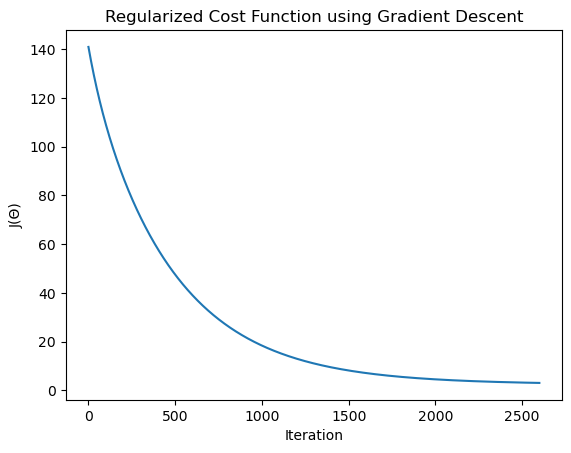

In [18]:
# n is now the new number of features after adding polynomial terms
n = X_poly_normalized.shape[1]

Lambda = 0
num_iter = 2600
learn_rate = 0.001

# inicialize theta vector with zeros
init_theta = np.zeros((n, 1))

# call gradientDescent to get the optimal parameters theta
theta_poly, J_history_poly = gradientDescent(X_poly_normalized,y,init_theta,learn_rate,num_iter,Lambda)

#Get Fig.5
plt.plot(J_history_poly)
#add labels
plt.title("Regularized Cost Function using Gradient Descent")
plt.xlabel("Iteration")
plt.ylabel("J(Θ)")

### Polynomial Regression - learning curves

Figs. 6 and Fig.7 are generated for $\lambda$=0.
The polynomial fit is able to follow the data points very well (Fig.6) and therefore the training error is very low (Fig.7). However, there is a gap between the training and CV errors (Fig.7), indicating a high variance problem due to the lack of regularization ( $\lambda$=0). 

<img src="images/f5.png" style="width:350px;height:250px;">
<caption><center> Fig.6: Polynomial Fit </center></caption>


<img src="images/f6.png" style="width:350px;height:250px;">
<caption><center> Fig.7: Linear Regression learning curves </center></caption>

(-5.0, 160.0)

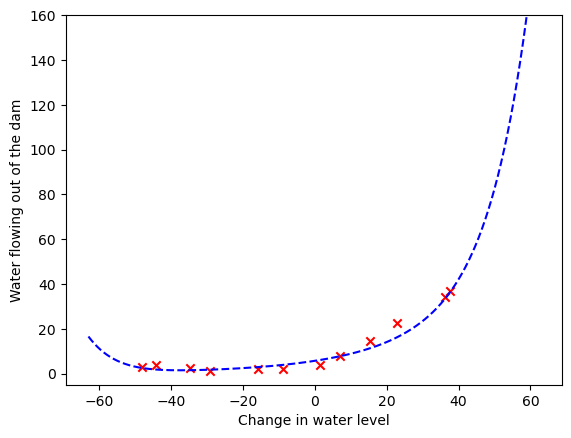

In [19]:
# Fig.6
# add the scatter plot of training data (as above) 
plt.scatter(X, y, marker="x", color="r")
plt.xlabel("Change in water level")
plt.ylabel("Water flowing out of the dam")

xmin = np.min(X) - 15
xmax=np.max(X) + 25

# Generate a grid of values for x coordinate
x_value=np.linspace(xmin,xmax,2400)
x_value=x_value.reshape(x_value.shape[0],1)

# Map the x values and normalize
x_value_poly = polyFeatures(x_value, degree)
x_value_poly = sc_X.transform(x_value_poly)
x_value_poly = np.append(np.ones((x_value_poly.shape[0],1)),x_value_poly, axis=1)

#Compute the model prediction for x_value_poly
y_value= np.dot(x_value_poly, theta_poly)

plt.plot(x_value,y_value,"--",color="b")
plt.ylim(-5,160)

In [20]:
# Call learningCurve to compute error_train and error_validation
error_train, error_val = learningCurve(X_poly_normalized, y, X_poly_val_normalized, yval, learn_rate, num_iter, Lambda)

(0.0, 100.0)

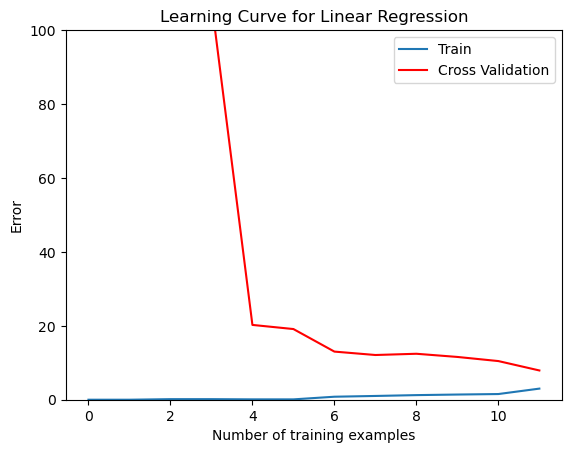

In [21]:
# Fig.7
plt.plot(range(m),error_train,label="Train")
plt.plot(range(m),error_val,label="Cross Validation",color="r")

plt.title("Learning Curve for Linear Regression")
plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.legend()
plt.ylim(0,100)

### Polynomial regression with $\lambda$ =  [0.001; 0.003; 0.01; 0.03; 0.1; 0.3; 1; 3; 10] ) 

Find the best $\lambda$ from a grid search and compute the training, validation and test errors.
(similar to function learningCurve)

In [25]:
def validationCurve(X, y, Xval, yval, learn_rate, num_iter, Lambda_array):

    """
    Returns the best lambda and the respective train and cross validation set errors
    """
    m = X.shape[0]  # Number of training examples 
    n = X.shape[1]  # number of features 
    mval = len(yval)  # Number of validation examples 
    
    error_train, error_val = [],[]
    
    for lam in Lambda_array:
        # inicialize theta vector with zeros
        
        theta_ini = np.zeros((n,1))
        
        # call gradientDescent to compute the optimal theta 
        theta = gradientDescent(X,y,theta_ini,learn_rate,num_iter,lam)[0]
                
        # After the training is over, apply the trained model for train and validation data
        pred_train = np.dot(X, theta)
        pred_val =  np.dot(Xval, theta)
        
        # Compute the train and validation error
        error_train_i = 1/(2*m) * np.sum((pred_train - y)**2)
        error_val_i = 1/(2*mval) * np.sum((pred_val - yval)**2)
        
        error_train.append(error_train_i)
        error_val.append(error_val_i)
    
    # Choose the best lambda to be the one that minimizes the validation error
    ind = np.argmin(error_val)
    best_lambda=Lambda_array[ind]
        
    return best_lambda, error_train, error_val

0.001
3.005297666022033
7.914728164723069
3.472665821513038


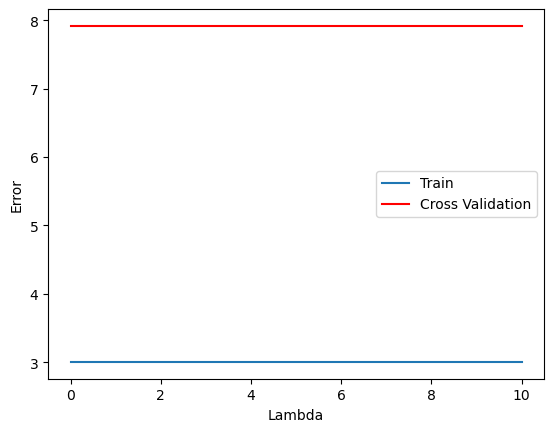

In [26]:
Lambda_array = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

best_lambda, error_train, error_val = validationCurve(X_poly_normalized, y, X_poly_val_normalized, yval, learn_rate, num_iter, Lambda_array)

print(best_lambda)

plt.plot(Lambda_array,error_train,label="Train")
plt.plot(Lambda_array,error_val,label="Cross Validation",color="r")
plt.xlabel("Lambda")
plt.ylabel("Error")
plt.legend()

# inicialize all thetas with zeros
theta_ini = np.zeros((n, 1))

# Train the model with the best_lambda
theta_poly = gradientDescent(X_poly_normalized, y,theta_ini,learn_rate,num_iter,best_lambda)[0]

# prediction of the Linear model for the training data 
pred = np.dot(X_poly_normalized,theta_poly)
# Training error
Etrain = 1/(2*m) * np.sum((pred - y)**2)

# prediction of the Linear model for the validation data 
pred_val = np.dot(X_poly_val_normalized, theta_poly)
# Validation error 
Eval = 1/(2*(len(yval))) * np.sum((pred_val - yval)**2)

#prediction of the Linear model for the test data 
pred_test = np.dot(X_poly_test_normalized, theta_poly)
# Test error 
Etest = 1/(2*(len(ytest))) * np.sum((pred_test - ytest)**2)

# print the training (Etrain), validation (Eval) and test (Etest) errors
print(Etrain)
print(Eval)
print(Etest)